In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

## Exercise 1

- Reload the IMDB data keeping only the first 20000 most common words
- pad the reviews to a shorter length (eg. 70 or 80), this time make sure you keep the first part of the review if it's longer than the maximum length
- re run the model (remember to set max_features correctly)
- does it train faster this time?
- do you get a better performance?

In [2]:
max_features = 20000

#### Dataset

In [3]:
from keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(
    '/tmp/imdb.npz',
    num_words=max_features,
    start_char=1,
    oov_char=2,
    index_from=3)

print(X_train.shape)
print(y_train.shape)
print('')
print(X_test.shape)
print(y_test.shape)

Using TensorFlow backend.


(25000,)
(25000,)

(25000,)
(25000,)


#### Normalize the size of X

In [4]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 80

X_train_pad = pad_sequences(X_train, maxlen=maxlen)
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

print(X_train_pad.shape)
print(X_test_pad.shape)

(25000, 80)
(25000, 80)


#### Model

In [5]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential

model = Sequential()

model.add(Embedding(
    input_dim=max_features,  # input = a number in range 0-max_features
    output_dim=128))         # output = 128D vector
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,609,473
Trainable params: 2,609,473
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(
    X_train_pad, y_train,
    batch_size=32, epochs=2, validation_split=0.3)

Train on 17500 samples, validate on 7500 samples
Epoch 1/2
17500/17500 [==============================] - 179s 10ms/step - loss: 0.4840 - acc: 0.7659 - val_loss: 0.4106 - val_acc: 0.8177
Epoch 2/2
17500/17500 [==============================] - 238s 14ms/step - loss: 0.3021 - acc: 0.8781 - val_loss: 0.3959 - val_acc: 0.8221


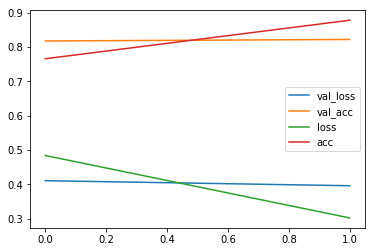

In [7]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot();

#### Evaluate

In [8]:
score, acc = model.evaluate(X_test_pad, y_test)

print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 39s 2ms/step
Test score: 0.39877927081108094
Test accuracy: 0.82192


## Exercise 2

- Reload the digits data as above
- define a function repeated_training_reg_dropout that adds regularization and dropout to a fully connected network
- compare the performance with/witouth dropout and regularization like we did for batch normalization
- do you get a better performance?

#### Dataset

In [9]:
from sklearn.datasets import load_digits

digits = load_digits()

X, y = digits.data, digits.target

display(X.shape)
display(y.shape)

(1797, 64)

(1797,)

#### Onehot Encoding y

In [10]:
from keras.utils import to_categorical

y_cat = to_categorical(y, 10)

print(y_cat.shape)

(1797, 10)


#### Train/Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat,
    test_size=0.3)

print(X_train.shape)
print(y_train.shape)
print('')
print(X_test.shape)
print(y_test.shape)

(1257, 64)
(1257, 10)

(540, 64)
(540, 10)


#### Model

In [12]:
def repeated_training_reg_dropout(
    X_train, y_train,
    X_test, y_test,
    units=512,
    activation='sigmoid', optimizer='sgd',
    do_dropout=False, rate=0.3,
    kernel_regularizer='l2',
    epochs=10, repeats=3):
    
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    import keras.backend as K

    histories = []
    
    for repeat in range(repeats):
        K.clear_session()

        model = Sequential()
        
        # first fully connected layer
        model.add(Dense(units,
                        input_shape=X_train.shape[1:],
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # second fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # third fully connected layer
        model.add(Dense(units,
                        kernel_initializer='normal',
                        kernel_regularizer=kernel_regularizer,
                        activation=activation))
        if do_dropout:
            model.add(Dropout(rate))

        # output layer
        model.add(Dense(10, activation='softmax'))
        
        model.compile(optimizer,
                      'categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train
        h = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs, verbose=0)
        histories.append([h.history['acc'], h.history['val_acc']])
        print(repeat, end=' ')
    
    
    # get stats
    histories = np.array(histories)
    
    # calculate mean and standard deviation across repeats:
    mean_acc = histories.mean(axis=0)
    std_acc = histories.std(axis=0)
    print()
    
    return mean_acc[0], std_acc[0], mean_acc[1], std_acc[1]

In [13]:
# Train without Dropout
mean_acc, std_acc, mean_acc_val, std_acc_val = repeated_training_reg_dropout(
    X_train, y_train,
    X_test, y_test,
    do_dropout=False)

0 1 2 


In [14]:
# Train with Dropout
mean_acc_do, std_acc_do, mean_acc_val_do, std_acc_val_do = repeated_training_reg_dropout(
    X_train, y_train,
    X_test, y_test,
    do_dropout=True)

0 1 2 


#### Evaluate

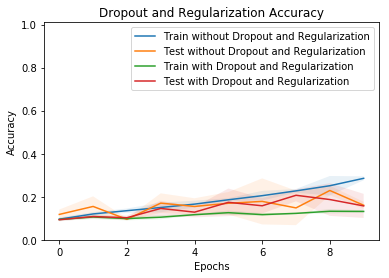

In [15]:
def plot_mean_std(m, s):
    # plot mean
    plt.plot(m)
    
    # Plot std
    plt.fill_between(range(len(m)), m-s, m+s, alpha=0.1)
    
    
plot_mean_std(mean_acc, std_acc)
plot_mean_std(mean_acc_val, std_acc_val)

plot_mean_std(mean_acc_do, std_acc_do)
plot_mean_std(mean_acc_val_do, std_acc_val_do)

plt.ylim(0, 1.01)
plt.title("Dropout and Regularization Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train without Dropout and Regularization', 'Test without Dropout and Regularization',
            'Train with Dropout and Regularization', 'Test with Dropout and Regularization'], loc='best')